In [ ]:
!pip install pandas numpy tensorflow scikit-learn matplotlib dvc PyYAML python-box==6.0.2 tqdm ensure==1.0.2 joblib types-PyYAML scipy Flask Flask-Cors

In [2]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import os



In [2]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Path to your train and test directory
train_dir = r'/content/drive/MyDrive/Malaria parasite images/Train'
test_path = r'/content/drive/MyDrive/Malaria parasite images/Test'


In [4]:
# Specify parameters for batch size, image height and width
batch_size = 32
img_height = 224
img_width = 224

In [5]:
def load_dataset(directory, target_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        class_label = 1 if class_name == 'uninfected' else 0
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_label)
    return np.array(images), np.array(labels)


In [6]:
# Load and split the data
X, y = load_dataset(train_dir)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (22072, 224, 224, 3)
y_train shape: (22072,)
X_val shape: (5518, 224, 224, 3)
y_val shape: (5518,)


In [7]:
# Check class distribution
train_infected = np.sum(y_train == 0)
train_uninfected = np.sum(y_train == 1)
val_infected = np.sum(y_val == 0)
val_uninfected = np.sum(y_val == 1)

print(f"Training set - Infected: {train_infected}, Uninfected: {train_uninfected}")
print(f"Validation set - Infected: {val_infected}, Uninfected: {val_uninfected}")


Training set - Infected: 11002, Uninfected: 11070
Validation set - Infected: 2795, Uninfected: 2723


In [8]:
# Creating model layers
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [9]:
# Create and compile the model
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
690/690 [==============================] - 266s 383ms/step - loss: 1.6793 - accuracy: 0.6840 - val_loss: 0.8050 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 2/25
690/690 [==============================] - 257s 373ms/step - loss: 0.6413 - accuracy: 0.9025 - val_loss: 0.5230 - val_accuracy: 0.9197 - lr: 1.0000e-04
Epoch 3/25
690/690 [==============================] - 257s 372ms/step - loss: 0.5147 - accuracy: 0.9195 - val_loss: 0.4530 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 4/25
690/690 [==============================] - 262s 380ms/step - loss: 0.4557 - accuracy: 0.9222 - val_loss: 0.4143 - val_accuracy: 0.9233 - lr: 1.0000e-04
Epoch 5/25
690/690 [==============================] - 259s 376ms/step - loss: 0.4186 - accuracy: 0.9223 - val_loss: 0.3853 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 6/25
690/690 [==============================] - 258s 374ms/step - loss: 0.3925 - accuracy: 0.9212 - val_loss: 0.3655 - val_accuracy: 0.9339 - lr: 1.0000e-04
Epoch 7/25
690/690 [==

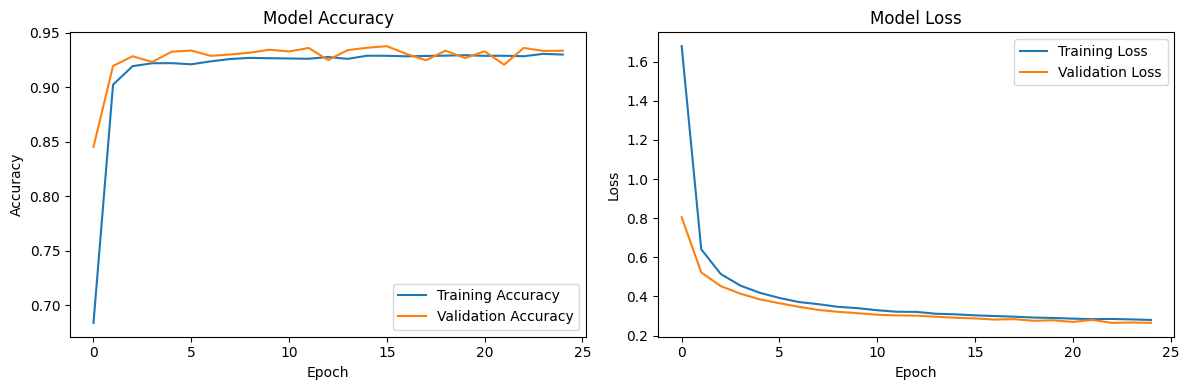

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function to predict and display results
def predict_and_display(model, img_path, target_size=(img_height, img_height)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        X = image.img_to_array(img)
        X = X / 255.0  # Normalize the image
        X = np.expand_dims(X, axis=0)

        val = model.predict(X)

        prediction = "uninfected" if val[0][0] > 0.5 else "infected"
        print(f"Predicted: {prediction}")

        return val[0][0]
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")
        return None

# Get list of all images and randomly select 100
all_images = os.listdir(test_path)
selected_images = random.sample(all_images, min(100, len(all_images)))

# Process selected images
results = []
true_labels = []
for i in selected_images:
    img_path = os.path.join(test_path, i)
    print(f"\nProcessing image: {i}")
    probability = predict_and_display(model, img_path)
    if probability is not None:
        results.append({'image': i, 'probability': probability})
        # Assuming the true label is in the filename (e.g., "infected_001.png")
        true_label = 1 if "uninfected" in i.lower() else 0
        true_labels.append(true_label)

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Image: {result['image']}, Probability of being uninfected: {result['probability']:.4f}")

# Calculate overall statistics
predicted_labels = [1 if r['probability'] > 0.5 else 0 for r in results]

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nTotal images processed: {len(results)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()